In [1]:
# Importing all the required packages
import warnings
warnings.filterwarnings("ignore")
from sklearn.datasets import load_boston
from random import seed
from random import randrange
from csv import reader
from math import sqrt
from sklearn import preprocessing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prettytable import PrettyTable
from sklearn.linear_model import SGDRegressor
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error

### Reading the dataset

In [2]:
X = load_boston().data
Y = load_boston().target

In [3]:
#Description of dataset
print(load_boston().DESCR)

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

### Preprocessing the dataset

In [4]:
# As the pre-loaded dataset is a numpy array, we are converting it to datadreame
# https://stackoverflow.com/questions/20763012/creating-a-pandas-dataframe-from-a-numpy-array-how-do-i-specify-the-index-colum
bos_df = pd.DataFrame(data=load_boston().data, columns=load_boston().feature_names)
print("The shape of data frame is", bos_df.shape)
print("\nThe top 5 rows of the  dataframe are")
bos_df.head()

The shape of data frame is (506, 13)

The top 5 rows of the  dataframe are


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [5]:
# Inserting the target variable in the dataframe
bos_df['price'] = load_boston().target
bos_df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,price
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [6]:
bos_df.columns

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT', 'price'],
      dtype='object')

In [7]:
# Checking if any null value is present in dataset
bos_df.isnull().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
price      0
dtype: int64

### Splitting the dataset into train and test

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

In [9]:
print("X_train shape is", X_train.shape)
print("y_train shape is", y_train.shape)
print("X_test shape is", X_test.shape)
print("y_test shape is", y_test.shape)

X_train shape is (339, 13)
y_train shape is (339,)
X_test shape is (167, 13)
y_test shape is (167,)


### Standardizing the dataset

In [10]:
from sklearn.preprocessing import StandardScaler
S = StandardScaler()
X_train = S.fit_transform(X_train)
X_test = S.transform(X_test)

### References used to implement SGD on Linear regression
1. https://machinelearningmastery.com/implement-linear-regression-stochastic-gradient-descent-scratch-python/
2. https://towardsdatascience.com/step-by-step-tutorial-on-linear-regression-with-stochastic-gradient-descent-1d35b088a843

### Implementing SGD from scratch

In [11]:
def pred(X,w,b):
    
    y_hat = []
    for i in range(0,len(X)):
        y = np.dot(X[i],w)+b
        #https://www.geeksforgeeks.org/numpy-asscalar-in-python
        y = np.asscalar(y)
        y_hat.append(y)
    y_hat = np.array(y_hat)
    
    return y_hat

In [12]:
def SGD(X, y, l_rate, epochs, l_rate_var):

    w=np.random.randn(X.shape[1],1)
    b=np.random.randn(1,1)
    
    n=X.shape[0]
    for epoch in range(1,epochs+1):
        sum_error=0
        
        for i in range(n):
            batch=np.random.randint(0,n)
            x_batch=X[batch,:].reshape(1,X.shape[1])
            y_batch=y[batch].reshape(1,1)
            
            y_pred=np.dot(x_batch,w)+b
            error=y_pred-y_batch
            
            sum_error += error**2
            dw=x_batch.T.dot((y_pred-y_batch))# Arrived logically by definition
            db=(y_pred-y_batch)
            
            w=w-(2/n)*l_rate*(dw)
            b=b-(2/n)*l_rate*(db)
        sum_error=sum_error/n
        print("Epoch :{0}  Total_error:{1}  lr_rate:{2}".format(epoch, np.round(sum_error,2), l_rate))
        
        if l_rate_var == 'constant':
            pass
        else :
            l_rate = l_rate/2
        
    return w,b

### Executing Sgd with constant learning rate for all epochs

In [13]:
w_best,b_best = SGD(X_train,y_train,l_rate=0.01, epochs=500, l_rate_var = 'constant')
Best_weights = pd.DataFrame(w_best,columns=['SGD_constant_l_rate'])

Epoch :1  Total_error:[[670.57]]  lr_rate:0.01
Epoch :2  Total_error:[[679.37]]  lr_rate:0.01
Epoch :3  Total_error:[[607.52]]  lr_rate:0.01
Epoch :4  Total_error:[[560.51]]  lr_rate:0.01
Epoch :5  Total_error:[[605.14]]  lr_rate:0.01
Epoch :6  Total_error:[[566.43]]  lr_rate:0.01
Epoch :7  Total_error:[[546.06]]  lr_rate:0.01
Epoch :8  Total_error:[[483.5]]  lr_rate:0.01
Epoch :9  Total_error:[[472.74]]  lr_rate:0.01
Epoch :10  Total_error:[[382.34]]  lr_rate:0.01
Epoch :11  Total_error:[[463.55]]  lr_rate:0.01
Epoch :12  Total_error:[[402.69]]  lr_rate:0.01
Epoch :13  Total_error:[[378.57]]  lr_rate:0.01
Epoch :14  Total_error:[[387.43]]  lr_rate:0.01
Epoch :15  Total_error:[[390.65]]  lr_rate:0.01
Epoch :16  Total_error:[[354.43]]  lr_rate:0.01
Epoch :17  Total_error:[[344.69]]  lr_rate:0.01
Epoch :18  Total_error:[[333.62]]  lr_rate:0.01
Epoch :19  Total_error:[[321.3]]  lr_rate:0.01
Epoch :20  Total_error:[[314.48]]  lr_rate:0.01
Epoch :21  Total_error:[[311.4]]  lr_rate:0.01
Epoc

Epoch :186  Total_error:[[23.17]]  lr_rate:0.01
Epoch :187  Total_error:[[26.3]]  lr_rate:0.01
Epoch :188  Total_error:[[24.37]]  lr_rate:0.01
Epoch :189  Total_error:[[24.54]]  lr_rate:0.01
Epoch :190  Total_error:[[26.55]]  lr_rate:0.01
Epoch :191  Total_error:[[20.56]]  lr_rate:0.01
Epoch :192  Total_error:[[25.13]]  lr_rate:0.01
Epoch :193  Total_error:[[25.4]]  lr_rate:0.01
Epoch :194  Total_error:[[23.61]]  lr_rate:0.01
Epoch :195  Total_error:[[27.99]]  lr_rate:0.01
Epoch :196  Total_error:[[24.49]]  lr_rate:0.01
Epoch :197  Total_error:[[21.63]]  lr_rate:0.01
Epoch :198  Total_error:[[24.84]]  lr_rate:0.01
Epoch :199  Total_error:[[24.28]]  lr_rate:0.01
Epoch :200  Total_error:[[28.8]]  lr_rate:0.01
Epoch :201  Total_error:[[29.65]]  lr_rate:0.01
Epoch :202  Total_error:[[26.33]]  lr_rate:0.01
Epoch :203  Total_error:[[15.47]]  lr_rate:0.01
Epoch :204  Total_error:[[26.42]]  lr_rate:0.01
Epoch :205  Total_error:[[20.87]]  lr_rate:0.01
Epoch :206  Total_error:[[23.58]]  lr_rate:

Epoch :371  Total_error:[[24.37]]  lr_rate:0.01
Epoch :372  Total_error:[[28.97]]  lr_rate:0.01
Epoch :373  Total_error:[[26.79]]  lr_rate:0.01
Epoch :374  Total_error:[[27.34]]  lr_rate:0.01
Epoch :375  Total_error:[[27.17]]  lr_rate:0.01
Epoch :376  Total_error:[[25.1]]  lr_rate:0.01
Epoch :377  Total_error:[[23.91]]  lr_rate:0.01
Epoch :378  Total_error:[[18.95]]  lr_rate:0.01
Epoch :379  Total_error:[[18.46]]  lr_rate:0.01
Epoch :380  Total_error:[[22.98]]  lr_rate:0.01
Epoch :381  Total_error:[[19.55]]  lr_rate:0.01
Epoch :382  Total_error:[[22.8]]  lr_rate:0.01
Epoch :383  Total_error:[[22.25]]  lr_rate:0.01
Epoch :384  Total_error:[[22.77]]  lr_rate:0.01
Epoch :385  Total_error:[[25.36]]  lr_rate:0.01
Epoch :386  Total_error:[[24.07]]  lr_rate:0.01
Epoch :387  Total_error:[[22.87]]  lr_rate:0.01
Epoch :388  Total_error:[[21.8]]  lr_rate:0.01
Epoch :389  Total_error:[[13.68]]  lr_rate:0.01
Epoch :390  Total_error:[[17.71]]  lr_rate:0.01
Epoch :391  Total_error:[[22.56]]  lr_rate:

Mean squared error 21.186219541861036


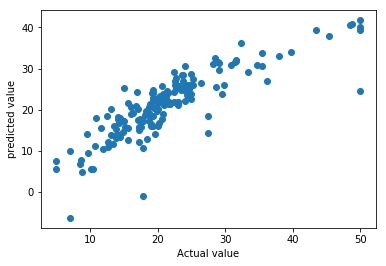

In [14]:
# Plotting line plot for actual vs model predicted 
# https://stackoverflow.com/questions/31069191/simple-line-plots-using-seaborn
import seaborn as sns
y_hat_1 = pred(X_test, w_best, b_best)
plt.scatter(x=y_test,y=y_hat_1)
plt.xlabel('Actual value')
plt.ylabel('predicted value')
ms_er1 = mean_squared_error(y_test,y_hat_1)
print("Mean squared error",ms_er1)

### Observations
1. From above we observe that loss is gradually reducing if learning rate is kept constant

### Executing SGD with different learning rate for all epochs

In [15]:
w_best,b_best=SGD(X_train,y_train,l_rate=1, epochs=500, l_rate_var = 'not constant')
Best_weights['SGD_varied_l_rate'] = pd.DataFrame(w_best,columns=['SGD_varied_l_rate'])

Epoch :1  Total_error:[[175.09]]  lr_rate:1
Epoch :2  Total_error:[[32.6]]  lr_rate:0.5
Epoch :3  Total_error:[[30.51]]  lr_rate:0.25
Epoch :4  Total_error:[[21.38]]  lr_rate:0.125
Epoch :5  Total_error:[[27.22]]  lr_rate:0.0625
Epoch :6  Total_error:[[18.08]]  lr_rate:0.03125
Epoch :7  Total_error:[[31.28]]  lr_rate:0.015625
Epoch :8  Total_error:[[22.01]]  lr_rate:0.0078125
Epoch :9  Total_error:[[20.04]]  lr_rate:0.00390625
Epoch :10  Total_error:[[22.38]]  lr_rate:0.001953125
Epoch :11  Total_error:[[32.7]]  lr_rate:0.0009765625
Epoch :12  Total_error:[[23.5]]  lr_rate:0.00048828125
Epoch :13  Total_error:[[22.5]]  lr_rate:0.000244140625
Epoch :14  Total_error:[[18.6]]  lr_rate:0.0001220703125
Epoch :15  Total_error:[[25.49]]  lr_rate:6.103515625e-05
Epoch :16  Total_error:[[23.55]]  lr_rate:3.0517578125e-05
Epoch :17  Total_error:[[24.43]]  lr_rate:1.52587890625e-05
Epoch :18  Total_error:[[26.7]]  lr_rate:7.62939453125e-06
Epoch :19  Total_error:[[30.5]]  lr_rate:3.814697265625e-

Epoch :132  Total_error:[[22.91]]  lr_rate:3.6734198463196485e-40
Epoch :133  Total_error:[[25.7]]  lr_rate:1.8367099231598242e-40
Epoch :134  Total_error:[[20.22]]  lr_rate:9.183549615799121e-41
Epoch :135  Total_error:[[26.]]  lr_rate:4.591774807899561e-41
Epoch :136  Total_error:[[28.31]]  lr_rate:2.2958874039497803e-41
Epoch :137  Total_error:[[20.22]]  lr_rate:1.1479437019748901e-41
Epoch :138  Total_error:[[19.86]]  lr_rate:5.739718509874451e-42
Epoch :139  Total_error:[[18.53]]  lr_rate:2.8698592549372254e-42
Epoch :140  Total_error:[[27.31]]  lr_rate:1.4349296274686127e-42
Epoch :141  Total_error:[[25.1]]  lr_rate:7.174648137343064e-43
Epoch :142  Total_error:[[23.62]]  lr_rate:3.587324068671532e-43
Epoch :143  Total_error:[[22.25]]  lr_rate:1.793662034335766e-43
Epoch :144  Total_error:[[22.8]]  lr_rate:8.96831017167883e-44
Epoch :145  Total_error:[[22.8]]  lr_rate:4.484155085839415e-44
Epoch :146  Total_error:[[20.8]]  lr_rate:2.2420775429197073e-44
Epoch :147  Total_error:[[

Epoch :261  Total_error:[[25.24]]  lr_rate:5.397605346934028e-79
Epoch :262  Total_error:[[26.1]]  lr_rate:2.698802673467014e-79
Epoch :263  Total_error:[[19.75]]  lr_rate:1.349401336733507e-79
Epoch :264  Total_error:[[22.5]]  lr_rate:6.747006683667535e-80
Epoch :265  Total_error:[[18.47]]  lr_rate:3.3735033418337674e-80
Epoch :266  Total_error:[[26.51]]  lr_rate:1.6867516709168837e-80
Epoch :267  Total_error:[[24.21]]  lr_rate:8.433758354584419e-81
Epoch :268  Total_error:[[17.77]]  lr_rate:4.2168791772922093e-81
Epoch :269  Total_error:[[24.2]]  lr_rate:2.1084395886461046e-81
Epoch :270  Total_error:[[22.31]]  lr_rate:1.0542197943230523e-81
Epoch :271  Total_error:[[24.46]]  lr_rate:5.271098971615262e-82
Epoch :272  Total_error:[[27.06]]  lr_rate:2.635549485807631e-82
Epoch :273  Total_error:[[24.6]]  lr_rate:1.3177747429038154e-82
Epoch :274  Total_error:[[27.31]]  lr_rate:6.588873714519077e-83
Epoch :275  Total_error:[[26.06]]  lr_rate:3.2944368572595385e-83
Epoch :276  Total_erro

Epoch :387  Total_error:[[29.46]]  lr_rate:6.344854593289123e-117
Epoch :388  Total_error:[[18.25]]  lr_rate:3.1724272966445615e-117
Epoch :389  Total_error:[[19.82]]  lr_rate:1.5862136483222808e-117
Epoch :390  Total_error:[[26.86]]  lr_rate:7.931068241611404e-118
Epoch :391  Total_error:[[20.75]]  lr_rate:3.965534120805702e-118
Epoch :392  Total_error:[[27.42]]  lr_rate:1.982767060402851e-118
Epoch :393  Total_error:[[24.13]]  lr_rate:9.913835302014255e-119
Epoch :394  Total_error:[[20.95]]  lr_rate:4.9569176510071274e-119
Epoch :395  Total_error:[[24.]]  lr_rate:2.4784588255035637e-119
Epoch :396  Total_error:[[27.92]]  lr_rate:1.2392294127517818e-119
Epoch :397  Total_error:[[25.57]]  lr_rate:6.196147063758909e-120
Epoch :398  Total_error:[[26.14]]  lr_rate:3.0980735318794546e-120
Epoch :399  Total_error:[[22.29]]  lr_rate:1.5490367659397273e-120
Epoch :400  Total_error:[[28.12]]  lr_rate:7.745183829698637e-121
Epoch :401  Total_error:[[18.21]]  lr_rate:3.8725919148493183e-121
Epoc

### Observation
1. We notice that there is a drastic change from 2nd epoch itself compared to the first approach i.e with constant learning       rate

Mean squared error 22.060186907739414


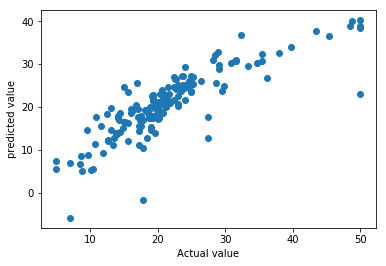

In [16]:
# Plotting line plot for actual vs model predicted 
# https://stackoverflow.com/questions/31069191/simple-line-plots-using-seaborn
import seaborn as sns
y_hat_1 = pred(X_test, w_best, b_best)
plt.scatter(x=y_test,y=y_hat_1)
plt.xlabel('Actual value')
plt.ylabel('predicted value')
ms_er2 = mean_squared_error(y_test,y_hat_1)
print("Mean squared error",ms_er2)

### Executing sklearn's SGDRegressor

In [17]:
from sklearn.linear_model import SGDRegressor
SGDR = SGDRegressor(loss='squared_loss', alpha=0.01, max_iter=500)
SGDR.fit(X_train,y_train)
y_hat = SGDR.predict(X_test)
Best_weights['SGDRegressor_scikit'] = SGDR.coef_

In [18]:
print(mean_squared_error(y_test, SGDR.predict(X_test)))

20.85601918948433


Mean squared error 20.85601918948433


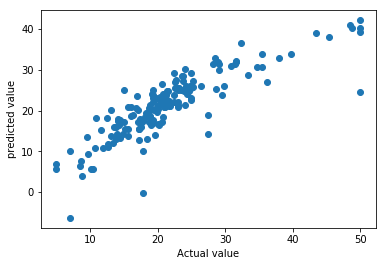

In [19]:
# Plotting line plot for actual vs model predicted 
# https://stackoverflow.com/questions/31069191/simple-line-plots-using-seaborn
import seaborn as sns
y_hat_1 = SGDR.predict(X_test)
plt.scatter(x=y_test,y=y_hat_1)
plt.xlabel('Actual value')
plt.ylabel('predicted value')
ms_er3 = mean_squared_error(y_test,y_hat_1)
print("Mean squared error",ms_er3)

In [20]:
Best_weights

,SGD_constant_l_rate,SGD_varied_l_rate,SGDRegressor_scikit
0,-0.840674,-0.795003,-0.942057
1,0.712502,0.655565,0.804730
2,-0.009761,-0.590807,0.314651
3,0.834394,1.314008,0.884120
4,-1.189070,-0.159156,-1.786730
5,2.872937,3.100020,2.825662
6,-0.429867,-0.575831,-0.362631
7,-2.711371,-2.332190,-2.903074
8,1.397033,1.688015,1.780323
9,-0.851373,-1.718437,-1.152708


In [21]:
print("Mean score for SGD_constant_l_rate",ms_er1)
print("Mean score for SGD_varied_l_rate",ms_er2)
print("Mean score for SGDRegressor_scikit",ms_er3)

Mean score for SGD_constant_l_rate 21.186219541861036
Mean score for SGD_varied_l_rate 22.060186907739414
Mean score for SGDRegressor_scikit 20.85601918948433
